# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in pythong using a few different techniques:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner)
1. Roberta Pretrained Model from Hugging Face
1. Huggingface Pipeline

## Step 0. Read in Data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from IPython.display import Markdown


plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import word_tokenize, sent_tokenize, pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\teddi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\teddi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Read in data
df = pd.read_csv('sampled_data.csv')
df.reset_index(inplace=True, drop=True)
print(df.shape)


(500, 10)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,125114,B000NY8OLK,A1I0PEMIH7L8Q,leo,10,10,1,1288310400,New recipe made in USA,Other reviewers have already said that the Lin...
1,16352,B007TJGZ54,ABYVECXXSP6R5,Lapimienta,0,0,5,1280707200,Excellent-love it!,This is the best k-cup coffee I've had. Its b...
2,25919,B000EVMNNC,A1JJ0QZIEENQ05,kms,0,2,3,1210636800,ok - but in small portions only,I completely liked these things --- BEFORE I g...
3,493952,B001F3HD06,A1CTTFNLP7MRYB,Dustin,0,0,5,1345161600,Good in Beer Too!!!,"First of all, I want to start off by saying th..."
4,223426,B002QGK2V8,A2MIUU3BJO38YJ,Ladner D. Brown,1,1,4,1259280000,"Smooth, creamy and interesting",I just received my box of Kahula and it wasn't...


#### Quick EDA

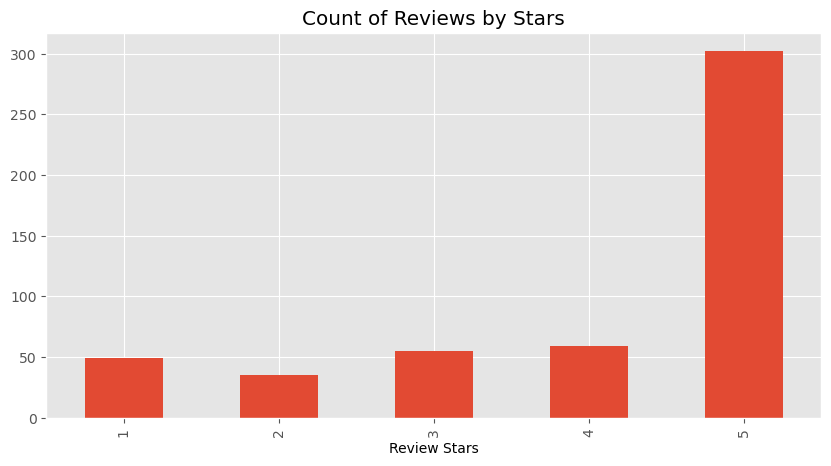

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot.bar(title='Count of Reviews by Stars', 
              figsize=(10, 5))
ax.set_xlabel('Review Stars')

plt.show()

## Basic NLTK

In [6]:
example = df['Text'][50]
print(example)

These are great.  I like the fact that they are in portion controlled bags which make them easy to throw in a book bag, carry-on bag or lunch box.  They are a bit hard so they don't crumble easily before you get to them.  The taste is similar to cinammon graham crackers.


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['These', 'are', 'great', '.', 'I', 'like', 'the', 'fact', 'that', 'they']

In [8]:
# Find part of speech
tagged = nltk.pos_tag(tokens) # see POS abbreviations and meanings at https://www.guru99.com/pos-tagging-chunking-nltk.html#1
tagged[:10]

[('These', 'DT'),
 ('are', 'VBP'),
 ('great', 'JJ'),
 ('.', '.'),
 ('I', 'PRP'),
 ('like', 'IN'),
 ('the', 'DT'),
 ('fact', 'NN'),
 ('that', 'IN'),
 ('they', 'PRP')]

In [9]:
# Next, lets take the POS tags and put into entities
entities = nltk.ne_chunk(tagged)
entities.pprint()

(S
  These/DT
  are/VBP
  great/JJ
  ./.
  I/PRP
  like/IN
  the/DT
  fact/NN
  that/IN
  they/PRP
  are/VBP
  in/IN
  portion/NN
  controlled/VBN
  bags/NNS
  which/WDT
  make/VBP
  them/PRP
  easy/JJ
  to/TO
  throw/VB
  in/IN
  a/DT
  book/NN
  bag/NN
  ,/,
  carry-on/JJ
  bag/NN
  or/CC
  lunch/NN
  box/NN
  ./.
  They/PRP
  are/VBP
  a/DT
  bit/RB
  hard/JJ
  so/IN
  they/PRP
  do/VBP
  n't/RB
  crumble/VB
  easily/RB
  before/IN
  you/PRP
  get/VBP
  to/TO
  them/PRP
  ./.
  The/DT
  taste/NN
  is/VBZ
  similar/JJ
  to/TO
  cinammon/VB
  graham/JJ
  crackers/NNS
  ./.)


## Step 1. VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the negative/neutral/postive scores of the text.

* This uses a "bag of words" approach:
    1. Stop words are removed
    1. Each word is scored and combined to a total score.

Note: This approach does not account for relationship between words.

In [10]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
# Create a function to get the polarity score for a given sentence
sia.polarity_scores('I am so happy to be coding with you all today!') # returns a dictionary of scores'

{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'compound': 0.6468}

In [12]:
sia.polarity_scores('This is worst time of night to be coding.') # compound score range is -1 (neg) to 1 (pos)

{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}

In [13]:
sia.polarity_scores(example)['compound']

0.7943

In [14]:
sia.polarity_scores(example)

{'neg': 0.06, 'neu': 0.773, 'pos': 0.167, 'compound': 0.7943}

In [15]:
# Run the polarity score on all reviews
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)
    

 20%|██        | 101/500 [00:00<00:00, 499.52it/s]

100%|██████████| 500/500 [00:00<00:00, 702.47it/s]


Lets store and view the results in a dataframe.


In [16]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left', on='Id')

Now we have sentiment scores  and metadata for each review.


In [17]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,125114,0.117,0.773,0.110,-0.1759,B000NY8OLK,A1I0PEMIH7L8Q,leo,10,10,1,1288310400,New recipe made in USA,Other reviewers have already said that the Lin...
1,16352,0.000,0.520,0.480,0.9690,B007TJGZ54,ABYVECXXSP6R5,Lapimienta,0,0,5,1280707200,Excellent-love it!,This is the best k-cup coffee I've had. Its b...
2,25919,0.164,0.733,0.103,-0.7102,B000EVMNNC,A1JJ0QZIEENQ05,kms,0,2,3,1210636800,ok - but in small portions only,I completely liked these things --- BEFORE I g...
3,493952,0.022,0.725,0.254,0.9740,B001F3HD06,A1CTTFNLP7MRYB,Dustin,0,0,5,1345161600,Good in Beer Too!!!,"First of all, I want to start off by saying th..."
4,223426,0.035,0.672,0.293,0.9695,B002QGK2V8,A2MIUU3BJO38YJ,Ladner D. Brown,1,1,4,1259280000,"Smooth, creamy and interesting",I just received my box of Kahula and it wasn't...


#### Plot VADER Results

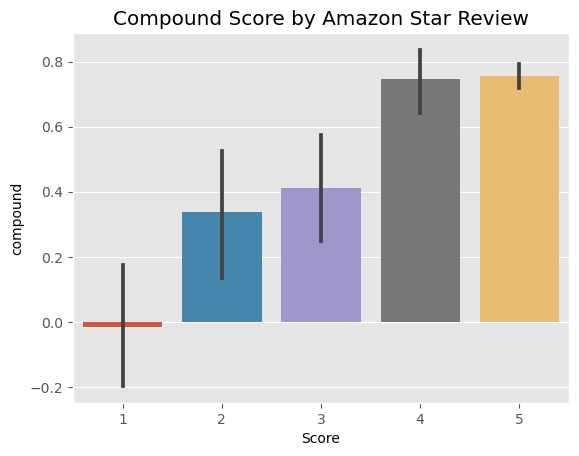

In [18]:
# Lets assume that a score of 5 is a positive review and a score of 1 is a negative review
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')

plt.show()

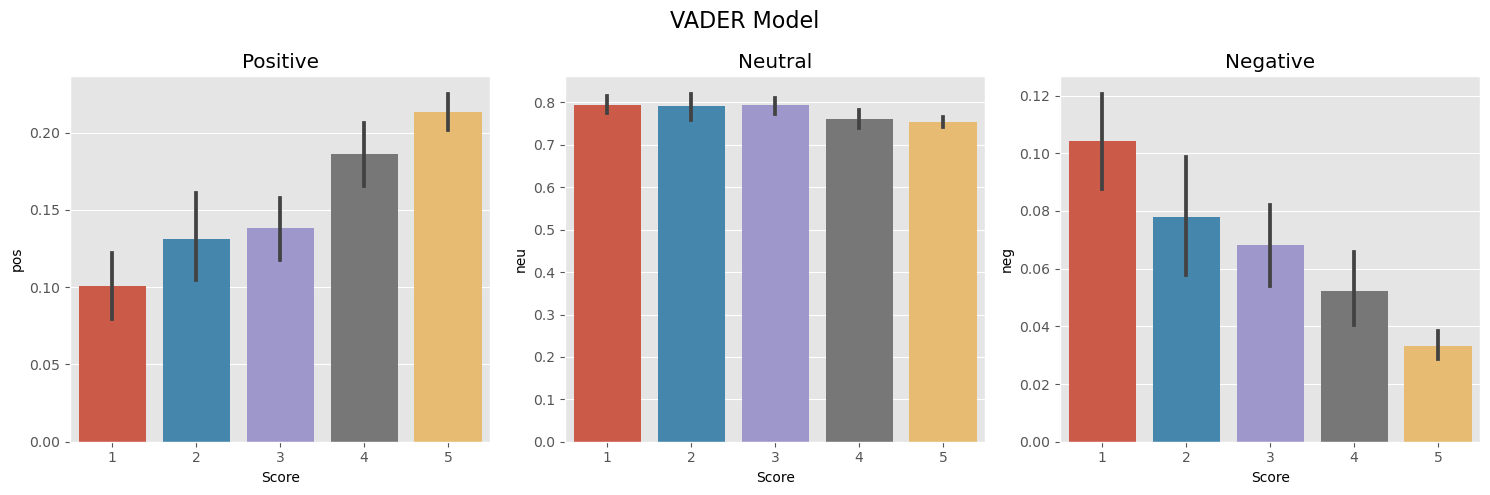

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')  

# Add a title above the subplots
fig.suptitle('VADER Model', fontsize=16)

plt.tight_layout()
plt.show()

Positivity is higher for the comment as the score increases in terms of stars.  For Neutral, it is flat.  And for Negative, we see that the negativity score for the comment decreases as the star score increases.

This just confirms what we would hope to see and show that VADER is valuable to illustrate the relationship between star score of the text and sentiment score.

## Step 2. Roberta Pretrained Model

* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also  the context related to other words.

Note:  The previous model just looked at each word in the comment and scored each word individually. But, human language depends a lot on the context.

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

c:\ProgramData\Anaconda3\envs\customerBehavior\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we are going to pull in a pre-trained model from Hugging Face. This was pre-trained on data from the Stanford Sentiment Treebank.

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
# VADER results on example
print(example)
sia.polarity_scores(example)

These are great.  I like the fact that they are in portion controlled bags which make them easy to throw in a book bag, carry-on bag or lunch box.  They are a bit hard so they don't crumble easily before you get to them.  The taste is similar to cinammon graham crackers.


{'neg': 0.06, 'neu': 0.773, 'pos': 0.167, 'compound': 0.7943}

In [23]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors="pt")
output = model(**encoded_text) # this is a tensor
scores = output[0][0].detach().numpy() # this is a numpy array so that we can store it locally.
scores = softmax(scores) # last step is to apply that softmax function
# scores # returns 3 different values in a numpy array, neg, neu, and pos.
scores_dict ={                   # create a dictionary to store the scores
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}   
print(scores_dict)                           

{'roberta_neg': 0.0024107539, 'roberta_neu': 0.017655436, 'roberta_pos': 0.97993386}


The Roberta model, as compared to the VADER, thinks that this review is more positive with respective scores of 0.9799 and 0.167, respectively; for this particular product.

Next, we will run this on the entire sampled dataset

In [24]:
# Create a function using the above code so that we can iterate over all reviews

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt")
    output = model(**encoded_text) # this is a tensor
    scores = output[0][0].detach().numpy() # this is a numpy array so that we can store it locally.
    scores = softmax(scores) # last step is to apply that softmax function
    scores_dict ={                   
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    } 
    return scores_dict

Run the polarity score on all reviews


In [25]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        review_id = row['Id']

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f'vader_{k}': v for k, v in vader_result.items()}

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result}
        results[review_id] = both
    except RuntimeError as e:
        print(f'Error for review ID {review_id}: {str(e)}')  
        pass

 12%|█▏        | 59/500 [00:19<03:01,  2.43it/s]

Error for review ID 119046: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 33%|███▎      | 164/500 [00:51<02:56,  1.90it/s]

Error for review ID 369795: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]


 70%|██████▉   | 349/500 [01:46<00:56,  2.67it/s]

Error for review ID 563900: The expanded size of the tensor (526) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 526].  Tensor sizes: [1, 514]


100%|██████████| 500/500 [02:22<00:00,  3.50it/s]


This broke for 3 examples.  We could have reduced the size of those and it would have worked. But its a good result for now. This was slow running, because ran using only the CPU and not GPU as the model was optimized to be run on GPUs.

Next, lets take these results and make the dictionary look similar to what we did earlier.

But first, lets store in a dataframe so that we can visualize it.

In [36]:
roberta = pd.DataFrame(results).T
roberta = roberta.reset_index().rename(columns={'index':'Id'})
roberta = roberta.merge(df, how='left', on='Id')

In [38]:
roberta.columns.to_list()

['Id',
 'vader_neg',
 'vader_neu',
 'vader_pos',
 'vader_compound',
 'roberta_neg',
 'roberta_neu',
 'roberta_pos',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

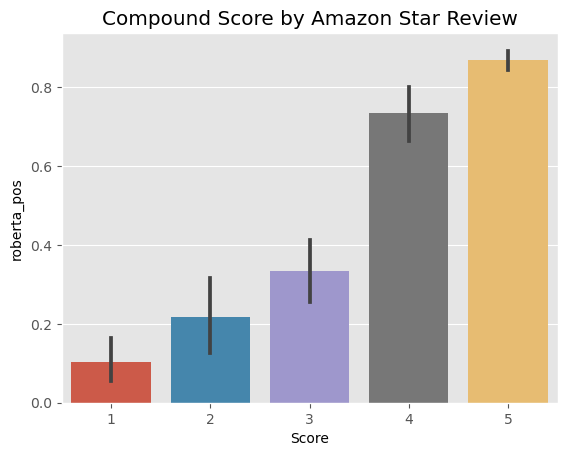

In [39]:
# Lets assume that a score of 5 is a positive review and a score of 1 is a negative review
ax = sns.barplot(data=roberta, x='Score', y='roberta_pos')
ax.set_title('RoBERTa Positive Score by Amazon Star Review')

plt.show()

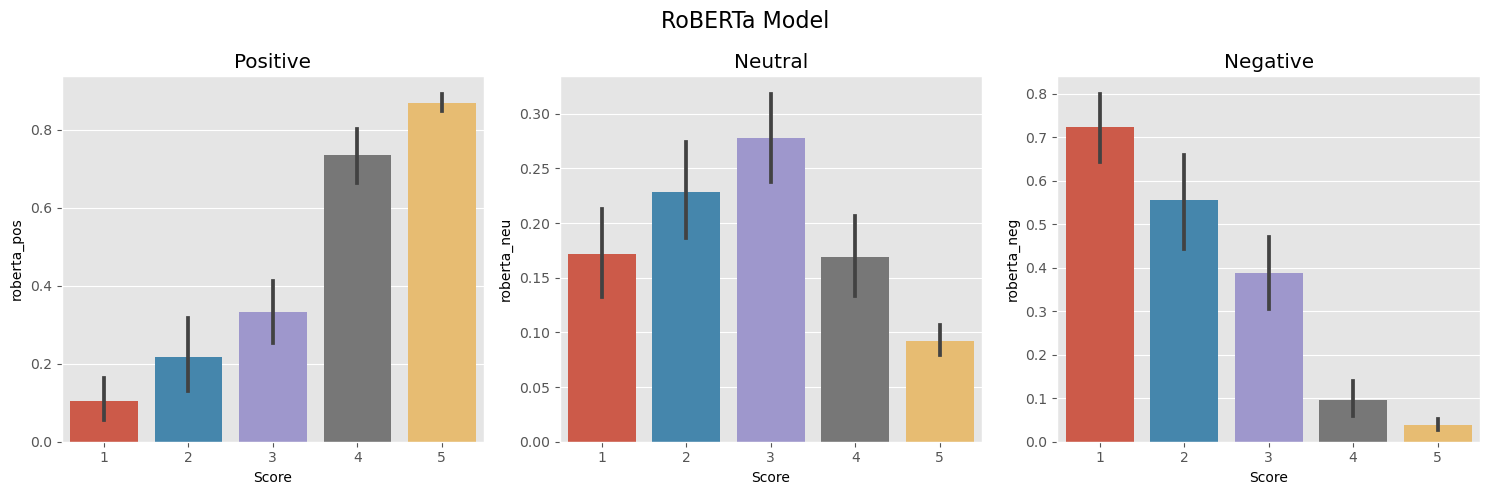

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=roberta, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=roberta, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')  

# Add a title above the subplots
fig.suptitle('RoBERTa Model', fontsize=16)

plt.tight_layout()
plt.show()

## Step 3. Combine and Compare

#### Compare Scores between Vader and Roberta Models

We will do this using seaborn's pairplot function. This function will plot all of the variables against each other. We will use the hue parameter to color the points by the star rating.

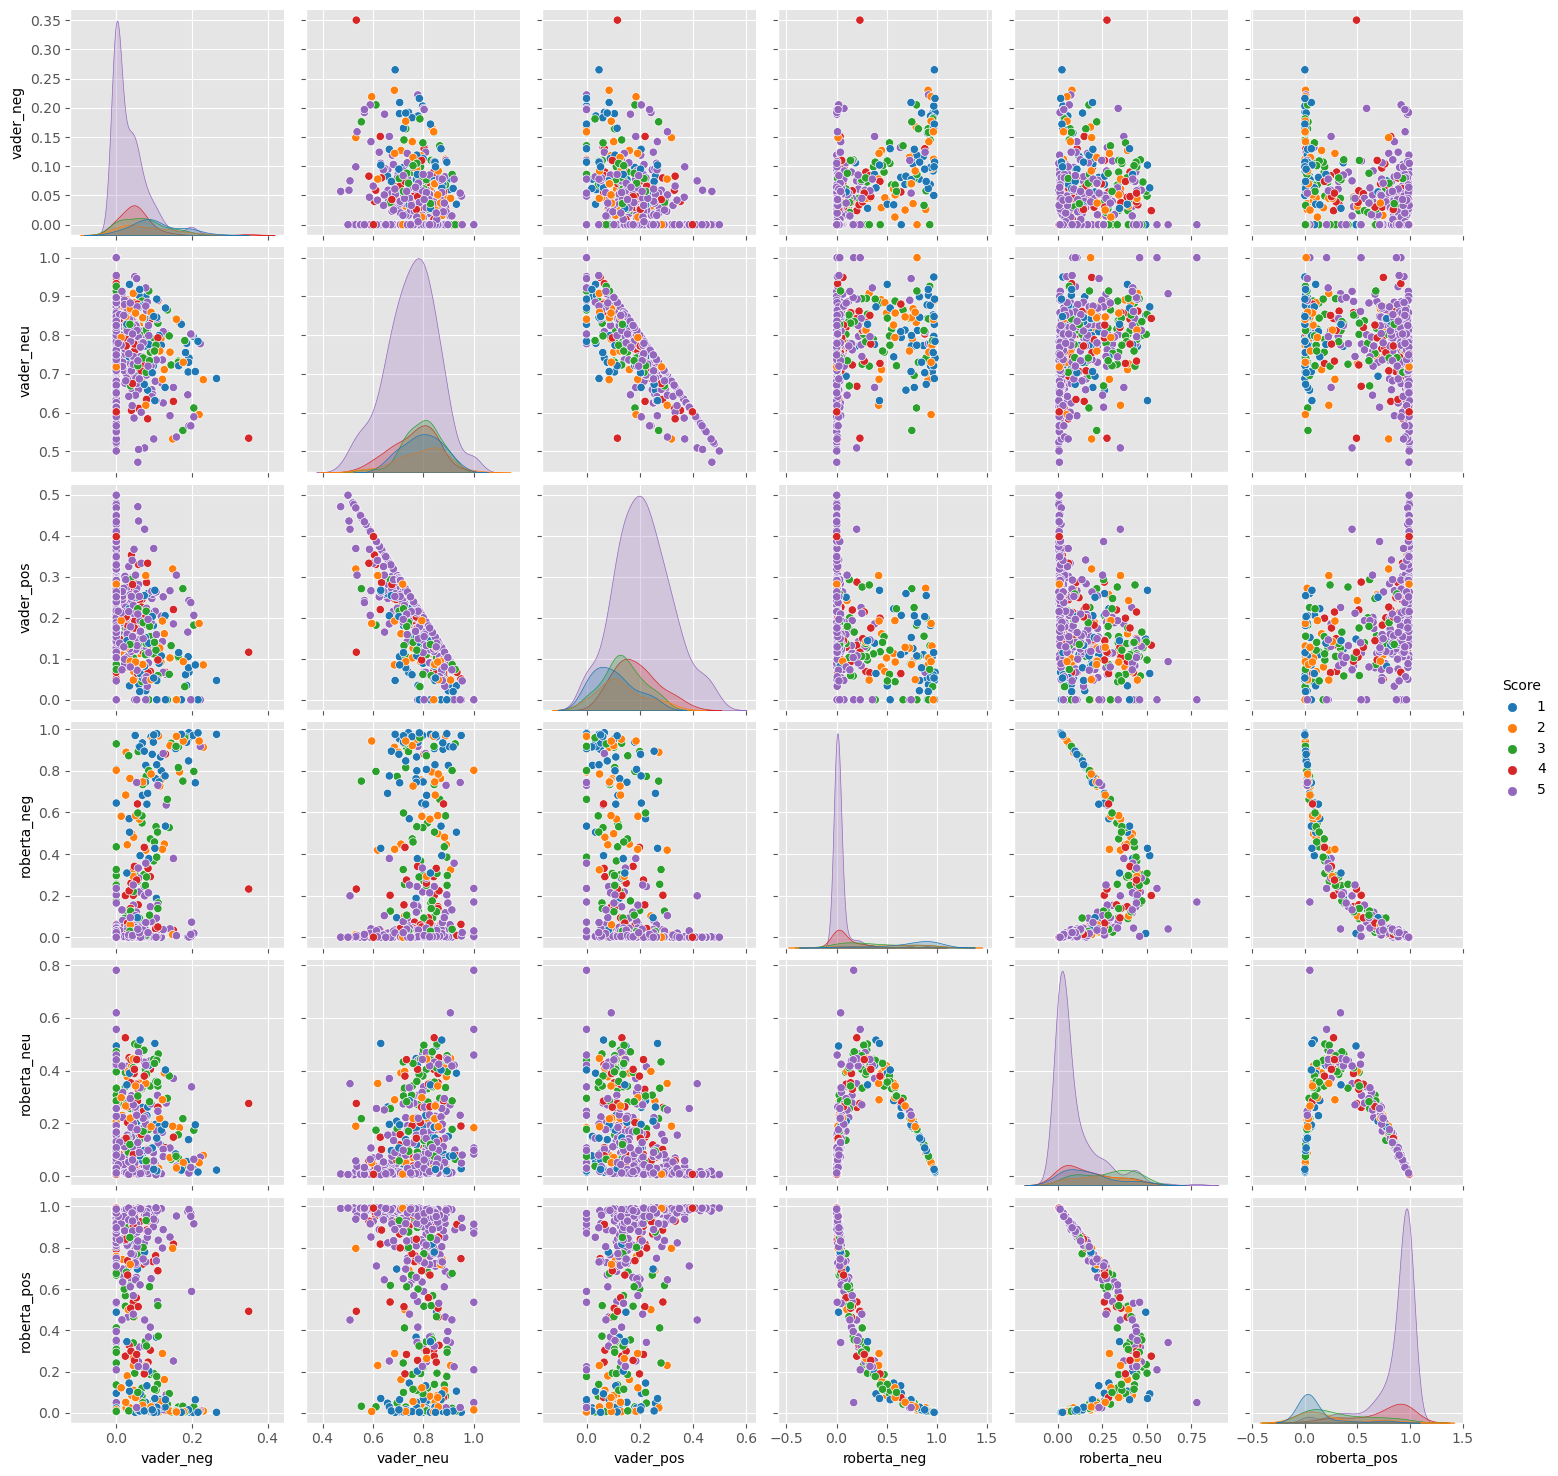

In [27]:
sns.pairplot(results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
                    'roberta_neu', 'roberta_pos'], 
                    hue='Score',
                    palette='tab10') 

plt.show()   

There is a lot going on here, but one thing that stands out is the 5-star reviews (purple). If we look at the Vader model, the positive reviews are centered, whereas for the Roberta model, the 5-star reviews are far to the right.

There does not appear to be a strong correlation between the 2 models.

The Roberta model appears to be more confident in its predictions with clear separation for positivity, neutral, and negativity scores for each of the predicted values; as compared to the Vader model.

## Step 4. Review Examples:

* Positive 1-Star and Negative 5-Star Reviews

Let's look at some examples where the model scoring and review score differ the most.


Positive Sentiment 1-Star Reviews

In [28]:
text = results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

# Define the desired width for word wrap
wrap_width = 80

# Wrap the text to the specified width
wrapped_text = textwrap.fill(text, width=wrap_width)

# Generate the Markdown-formatted text with italics
italic_text = f"*{wrapped_text}*"

# Display the text in italics using Markdown
display(Markdown(italic_text))


*Just got my order in today. I unpacked it and went to put them in my cupboard,
and I discovered 8 dented cans. 8 out of 12! 5 of them were severely dented. The
Amazon packaging was fine and it was in a larger box with other items which were
not damaged, so it was packaged like that at the manufacturer. I was hoping the
bad reviews from last year were fixed but I guess not. These cans were from
Thailand (not Sri Lanka) so atleast they fixed that issue. I'm most likely going
to find a different brand after this!<br /><br />Amazon of course is amazing and
they already have a replacement shipment on the way. Hopefully they checked it
before it left and I don't get anymore dented cans!*

Here we are looking at text that is said to be positive by the model, but was given a 1 score (1 Star rating).

Let's repeat this but using the Vader score this time

In [29]:
from IPython.display import Markdown

text = results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

# Define the desired width for word wrap
wrap_width = 80

# Wrap the text to the specified width
wrapped_text = textwrap.fill(text, width=wrap_width)

# Generate the Markdown-formatted text with italics
italic_text = f"*{wrapped_text}*"

# Display the text in italics using Markdown
display(Markdown(italic_text))

*I'm pretty sure this is just brown sugar. It is not like Sucanat. I gave it
away.*

Here the Vader model predicted this to have more positivity while, when taken in context, it is more evident that this is a negative review and hence, the 1-star rating.


Negative Sentiment 5-Star Review

* Roberta model

In [30]:
text = results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

# Define the desired width for word wrap
wrap_width = 80

# Wrap the text to the specified width
wrapped_text = textwrap.fill(text, width=wrap_width)

# Generate the Markdown-formatted text with italics
italic_text = f"*{wrapped_text}*"

# Display the text in italics using Markdown
display(Markdown(italic_text))

*Our dogs freak over these!  The only downside is that they are messy.  These are
small pieces of lamb and rice inside a trachea, and once chewed open, they get
everywhere.*

* Vader model

In [31]:
text = results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Define the desired width for word wrap
wrap_width = 80

# Wrap the text to the specified width
wrapped_text = textwrap.fill(text, width=wrap_width)

# Generate the Markdown-formatted text with italics
italic_text = f"*{wrapped_text}*"

# Display the text in italics using Markdown
display(Markdown(italic_text))

*Our dogs freak over these!  The only downside is that they are messy.  These are
small pieces of lamb and rice inside a trachea, and once chewed open, they get
everywhere.*

## Hugging Face Transformers Pipeline

* Quick and easy way to run sentiment predictions

In [32]:
from transformers import pipeline

# Specify the sentiment analysis model
#model_name = "bert-base-uncased"

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [33]:
sentiment_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [34]:
sentiment_pipeline('I hate math')

[{'label': 'NEGATIVE', 'score': 0.9988335967063904}]

## The End